Task 0.1

In [1]:
import torchvision
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import torch


In [2]:
# Define a transform to normalize the data
mytransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalize with a mean of 0.5 and a std och 0.5 (X-mean)/std - per channel
])

#download data
traindataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=mytransform
    )

testdataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=mytransform
    )
batch_size=64
trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testdataset, batch_size=batch_size, shuffle=True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..1.0].
Clipping input d

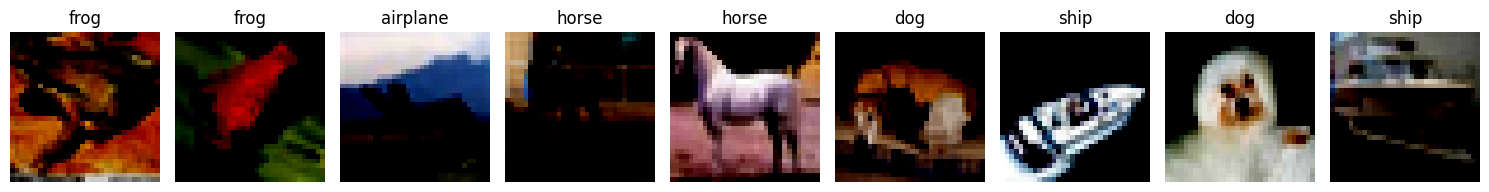

In [3]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

def show_some_images(dataloader, class_names, num_images=9):
    
    images, labels = next(iter(dataloader))  # Get a batch of images
    indices = np.random.choice(images.shape[0], num_images, replace=False)  # Random selection
    selected_images = images[indices]
    selected_labels = labels[indices]

    # Create figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, (img, label) in enumerate(zip(selected_images, selected_labels)):
        img = np.transpose(img.numpy(), (1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_names[label.item()])  # Set class label as title

    plt.tight_layout()
    plt.show()

show_some_images(trainloader, trainloader.dataset.classes)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes for CIFAR-10
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # LeakyReLU activation

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.pool(x)

        x = self.leaky_relu(self.conv2(x))
        x = self.pool(x)

        x = self.leaky_relu(self.conv3(x))
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)  # Flatten for fully connected layers
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)  # No activation (logits for classification)
        
        return x

# Create an instance of the network
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)


In [5]:
import torch.optim as optim
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [6]:

def trainloop(optimizer,criterion,trainloader,testloader,  model, num_epochs = 10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
    
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            # Calculate accuracy within the training loop
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        epoch_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Evaluate the model on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

        
trainloop(optimizer,criterion,trainloader,testloader, model)

Epoch 1, Loss: 2.3029, Accuracy: 11.10%
Epoch 2, Loss: 2.3028, Accuracy: 11.26%
Epoch 3, Loss: 2.3027, Accuracy: 11.42%
Epoch 4, Loss: 2.3026, Accuracy: 11.54%
Epoch 5, Loss: 2.3025, Accuracy: 11.71%
Epoch 6, Loss: 2.3025, Accuracy: 11.81%
Epoch 7, Loss: 2.3024, Accuracy: 11.94%
Epoch 8, Loss: 2.3023, Accuracy: 12.08%
Epoch 9, Loss: 2.3022, Accuracy: 12.09%
Epoch 10, Loss: 2.3021, Accuracy: 12.14%
Test Accuracy: 12.40%


In [7]:
#OK to prove this code is correct, its just a bad model and bad lr
model = SimpleCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)
trainloop(optimizer,criterion,trainloader,testloader, model)

Epoch 1, Loss: 2.2998, Accuracy: 13.04%
Epoch 2, Loss: 2.2434, Accuracy: 21.15%
Epoch 3, Loss: 1.9350, Accuracy: 30.17%
Epoch 4, Loss: 1.7232, Accuracy: 37.23%
Epoch 5, Loss: 1.5714, Accuracy: 42.45%
Epoch 6, Loss: 1.4771, Accuracy: 46.13%
Epoch 7, Loss: 1.3988, Accuracy: 49.27%
Epoch 8, Loss: 1.3336, Accuracy: 51.72%
Epoch 9, Loss: 1.2692, Accuracy: 54.26%
Epoch 10, Loss: 1.2065, Accuracy: 57.02%
Test Accuracy: 57.48%


In [8]:
#restarts model
model = SimpleCNN()
# Define Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
trainloop(optimizer,criterion,trainloader,testloader,  model)

Epoch 1, Loss: 1.7613, Accuracy: 35.51%
Epoch 2, Loss: 1.4373, Accuracy: 47.86%
Epoch 3, Loss: 1.3175, Accuracy: 52.57%
Epoch 4, Loss: 1.2268, Accuracy: 56.22%
Epoch 5, Loss: 1.1495, Accuracy: 59.01%
Epoch 6, Loss: 1.0840, Accuracy: 61.68%
Epoch 7, Loss: 1.0232, Accuracy: 63.83%
Epoch 8, Loss: 0.9738, Accuracy: 65.77%
Epoch 9, Loss: 0.9252, Accuracy: 67.30%
Epoch 10, Loss: 0.8806, Accuracy: 69.14%
Test Accuracy: 67.67%


In [9]:
# Define a small CNN model
class SmallCNNtanh(nn.Module):
    def __init__(self):
        super(SmallCNNtanh, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.leaky_relu = nn.LeakyReLU()
        self.tanh=nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)  # No activation (logits for classification)
        return x
modeltanh = SmallCNNtanh()
optimizer = optim.Adam(modeltanh.parameters(), lr=0.0001)
print(modeltanh)

SmallCNNtanh(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (tanh): Tanh()
)


In [10]:
trainloop(optimizer,criterion,trainloader,testloader,  modeltanh)

Epoch 1, Loss: 1.6377, Accuracy: 42.81%
Epoch 2, Loss: 1.3525, Accuracy: 52.80%
Epoch 3, Loss: 1.2146, Accuracy: 57.55%
Epoch 4, Loss: 1.1239, Accuracy: 60.82%
Epoch 5, Loss: 1.0572, Accuracy: 63.38%
Epoch 6, Loss: 0.9975, Accuracy: 65.50%
Epoch 7, Loss: 0.9463, Accuracy: 67.22%
Epoch 8, Loss: 0.9038, Accuracy: 68.84%
Epoch 9, Loss: 0.8633, Accuracy: 70.50%
Epoch 10, Loss: 0.8281, Accuracy: 71.67%
Test Accuracy: 67.48%


Task 0.2


In [11]:
from torchvision.models import alexnet
model_alex = alexnet(pretrained=False)  # Set to True to use pretrained ImageNet weights
print(model_alex)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
model_alex.classifier[6] = nn.Linear(4096, 10)  # Modify final layer for CIFAR-10 (10 classes)

#apprently we need to make bigger input sizes:
mytransform2 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (AlexNet input size)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
traindataset2 = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=mytransform2
    )

testdataset2 = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=mytransform2
    )
batch_size=64
trainloader2 = DataLoader(traindataset2, batch_size=batch_size, shuffle=True)
testloader2 = DataLoader(testdataset2, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model_alex.parameters(), lr=0.0001)
trainloop(optimizer,criterion,trainloader2,testloader2,  model_alex)

Epoch 1, Loss: 1.5277, Accuracy: 43.38%
Epoch 2, Loss: 1.0674, Accuracy: 61.66%
Epoch 3, Loss: 0.8467, Accuracy: 70.17%
Epoch 4, Loss: 0.6949, Accuracy: 75.64%
Epoch 5, Loss: 0.5888, Accuracy: 79.56%
Epoch 6, Loss: 0.4985, Accuracy: 82.67%
Epoch 7, Loss: 0.4294, Accuracy: 84.87%
Epoch 8, Loss: 0.3653, Accuracy: 87.24%
Epoch 9, Loss: 0.3023, Accuracy: 89.41%
Epoch 10, Loss: 0.2570, Accuracy: 91.03%
Test Accuracy: 79.64%


In [13]:
from torchvision.models import AlexNet_Weights
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_alex_fine = alexnet(weights=AlexNet_Weights.DEFAULT)  # Set to True to use pretrained ImageNet weights
model_alex_fine.classifier[6] = nn.Linear(4096, 10)  # Modify final layer for CIFAR-10 (10 classes)

#model_alex_fine.to(device)
optimizer = optim.Adam(model_alex_fine.parameters(), lr=0.0001)
trainloop(optimizer,criterion,trainloader2,testloader2,  model_alex_fine)

Epoch 1, Loss: 0.5705, Accuracy: 80.09%
Epoch 2, Loss: 0.3121, Accuracy: 89.13%
Epoch 3, Loss: 0.2099, Accuracy: 92.69%
Epoch 4, Loss: 0.1516, Accuracy: 94.70%
Epoch 5, Loss: 0.1137, Accuracy: 96.01%
Epoch 6, Loss: 0.0898, Accuracy: 96.82%
Epoch 7, Loss: 0.0739, Accuracy: 97.38%
Epoch 8, Loss: 0.0668, Accuracy: 97.73%
Epoch 9, Loss: 0.0574, Accuracy: 97.99%
Epoch 10, Loss: 0.0546, Accuracy: 98.04%
Test Accuracy: 89.73%


In [14]:

model_alex_pretrained = alexnet(weights=AlexNet_Weights.DEFAULT)  # Set to True to use pretrained ImageNet weights

# Freeze all layers
for param in model_alex_pretrained.parameters():
    param.requires_grad = False

# Modify the last layer for CIFAR-10 (10 classes)
model_alex_pretrained.classifier[6] = nn.Linear(4096, 10)  # Modify final layer for CIFAR-10 (10 classes)
# Enable learning for the last layer
for param in model_alex_pretrained.classifier[6].parameters():
    param.requires_grad = True

In [15]:
optimizer = optim.Adam(model_alex_pretrained.parameters(), lr=0.0001)
trainloop(optimizer,criterion,trainloader2,testloader2,  model_alex_pretrained)

Epoch 1, Loss: 1.1313, Accuracy: 62.45%
Epoch 2, Loss: 0.8580, Accuracy: 70.27%
Epoch 3, Loss: 0.8007, Accuracy: 72.17%
Epoch 4, Loss: 0.7736, Accuracy: 73.17%
Epoch 5, Loss: 0.7539, Accuracy: 73.73%
Epoch 6, Loss: 0.7394, Accuracy: 74.18%
Epoch 7, Loss: 0.7278, Accuracy: 74.44%
Epoch 8, Loss: 0.7174, Accuracy: 74.99%
Epoch 9, Loss: 0.7080, Accuracy: 74.98%
Epoch 10, Loss: 0.7054, Accuracy: 75.31%
Test Accuracy: 74.09%


In [16]:
#loading the MINST dataset
#download data
transformMNIST = transforms.Compose([
    transforms.ToTensor(),  # Converts image to tensor with shape [1, 28, 28]
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])


traindatasetMNIST = torchvision.datasets.MNIST(
        root='./dataMNIST', train=True, download=True, transform=transformMNIST
    )

testdatasetMNIST = torchvision.datasets.MNIST(
        root='./dataMNIST', train=False, download=True, transform=transformMNIST
    )
batch_size=64
trainloaderMNIST = DataLoader(traindatasetMNIST, batch_size=batch_size, shuffle=True)
testloaderMNIST = DataLoader(testdatasetMNIST, batch_size=batch_size, shuffle=True)

#show_some_images(trainloaderMNIST, trainloaderMNIST.dataset.classes)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNNMnist(nn.Module):
    def __init__(self):
        super(SimpleCNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) #adjusted nr of in_channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(128 * 7 * 7, 256) #modified this
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes for CIFAR-10-same MNIST...
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # LeakyReLU activation

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.pool(x) #(W-F+2P)/S+1 (28-3+2)/2+1= 14

        x = self.leaky_relu(self.conv2(x))
        x = self.pool(x) #(W-F+2P)/S+1 (14-3+2)/2+1= 7

        x = self.leaky_relu(self.conv3(x))
        #x = self.pool(x) #cuts this because 7/2---

        x = torch.flatten(x, start_dim=1)  # Flatten for fully connected layers
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)  # No activation (logits for classification)
        
        return x

# Create an instance of the network
model = SimpleCNNMnist()
print(model)

SimpleCNNMnist(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)


In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
trainloop(optimizer,criterion,trainloaderMNIST,testloaderMNIST, model)

Epoch 1, Loss: 0.3327, Accuracy: 90.16%
Epoch 2, Loss: 0.0823, Accuracy: 97.49%
Epoch 3, Loss: 0.0567, Accuracy: 98.25%
Epoch 4, Loss: 0.0434, Accuracy: 98.66%
Epoch 5, Loss: 0.0348, Accuracy: 98.92%
Epoch 6, Loss: 0.0272, Accuracy: 99.14%
Epoch 7, Loss: 0.0235, Accuracy: 99.22%
Epoch 8, Loss: 0.0199, Accuracy: 99.36%
Epoch 9, Loss: 0.0166, Accuracy: 99.47%
Epoch 10, Loss: 0.0142, Accuracy: 99.55%
Test Accuracy: 99.00%


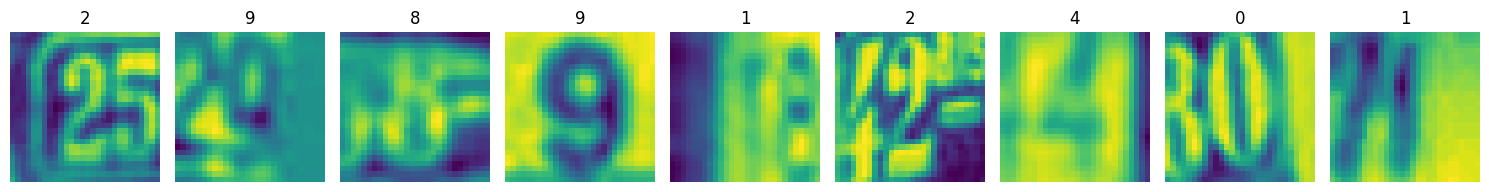

In [19]:
#Save model to file
torch.save(model.state_dict(), "mnist_cnn.pth")


#use a transform to make data similar to MNIST
transformToMNIST = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


#loading the SVHN dataset
traindatasetSVHN = torchvision.datasets.SVHN(
        root='./dataSVHN', split='train', download=True, transform=transformToMNIST
    )

testdatasetSVHN = torchvision.datasets.SVHN(
        root='./dataSVHN', split='test', download=True, transform=transformToMNIST
    )
batch_size=64
trainloaderSVHN = DataLoader(traindatasetSVHN, batch_size=batch_size, shuffle=True)
testloaderSVHN = DataLoader(testdatasetSVHN, batch_size=batch_size, shuffle=True)

show_some_images(trainloaderSVHN, range(10))


#make a new model...:
modelSVHN=SimpleCNNMnist()
modelSVHN.load_state_dict(torch.load("mnist_cnn.pth"))

# Freeze all layers
for param in modelSVHN.parameters():
    param.requires_grad = False

# Modify final layer for SVHN classification (10 digits)
modelSVHN.fc3 = nn.Linear(128, 10)


In [20]:
    # Evaluate the model on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloaderSVHN:
            outputs = modelSVHN(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 12.99%


In [21]:
optimizer = optim.Adam(modelSVHN.parameters(), lr=0.0001)
trainloop(optimizer,criterion,trainloaderSVHN,testloaderSVHN, modelSVHN)

Epoch 1, Loss: 2.0933, Accuracy: 26.37%
Epoch 2, Loss: 1.8674, Accuracy: 37.16%
Epoch 3, Loss: 1.7760, Accuracy: 40.81%
Epoch 4, Loss: 1.7204, Accuracy: 43.08%
Epoch 5, Loss: 1.6810, Accuracy: 44.74%
Epoch 6, Loss: 1.6509, Accuracy: 45.91%
Epoch 7, Loss: 1.6266, Accuracy: 46.92%
Epoch 8, Loss: 1.6063, Accuracy: 47.79%
Epoch 9, Loss: 1.5889, Accuracy: 48.54%
Epoch 10, Loss: 1.5736, Accuracy: 49.20%
Test Accuracy: 53.63%


In [22]:
modelSVHNfullytrained=SimpleCNNMnist()
optimizer = optim.Adam(modelSVHNfullytrained.parameters(), lr=0.0001)
trainloop(optimizer,criterion,trainloaderSVHN,testloaderSVHN, modelSVHNfullytrained)

#kör model.to(device)

Epoch 1, Loss: 1.3749, Accuracy: 54.09%
Epoch 2, Loss: 0.6429, Accuracy: 80.89%
Epoch 3, Loss: 0.5122, Accuracy: 84.90%
Epoch 4, Loss: 0.4416, Accuracy: 86.95%
Epoch 5, Loss: 0.3926, Accuracy: 88.38%
Epoch 6, Loss: 0.3504, Accuracy: 89.65%
Epoch 7, Loss: 0.3185, Accuracy: 90.53%
Epoch 8, Loss: 0.2887, Accuracy: 91.52%
Epoch 9, Loss: 0.2633, Accuracy: 92.32%
Epoch 10, Loss: 0.2401, Accuracy: 93.05%
Test Accuracy: 89.72%
